In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.pylab as plt
from math import log, sqrt, exp

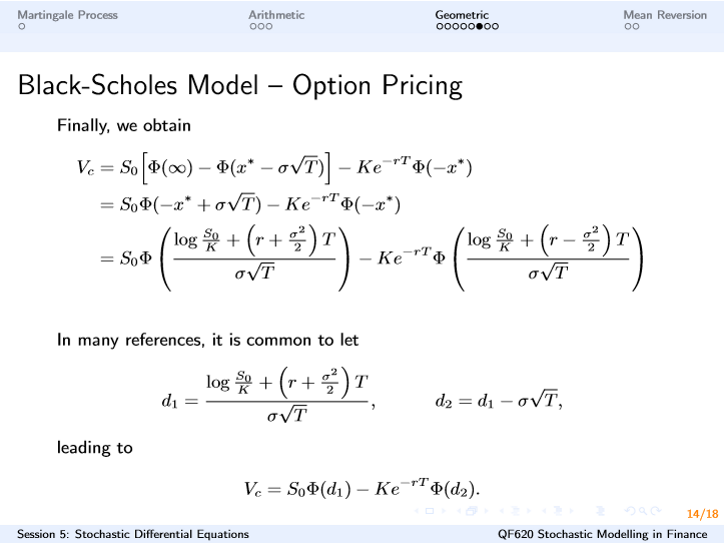

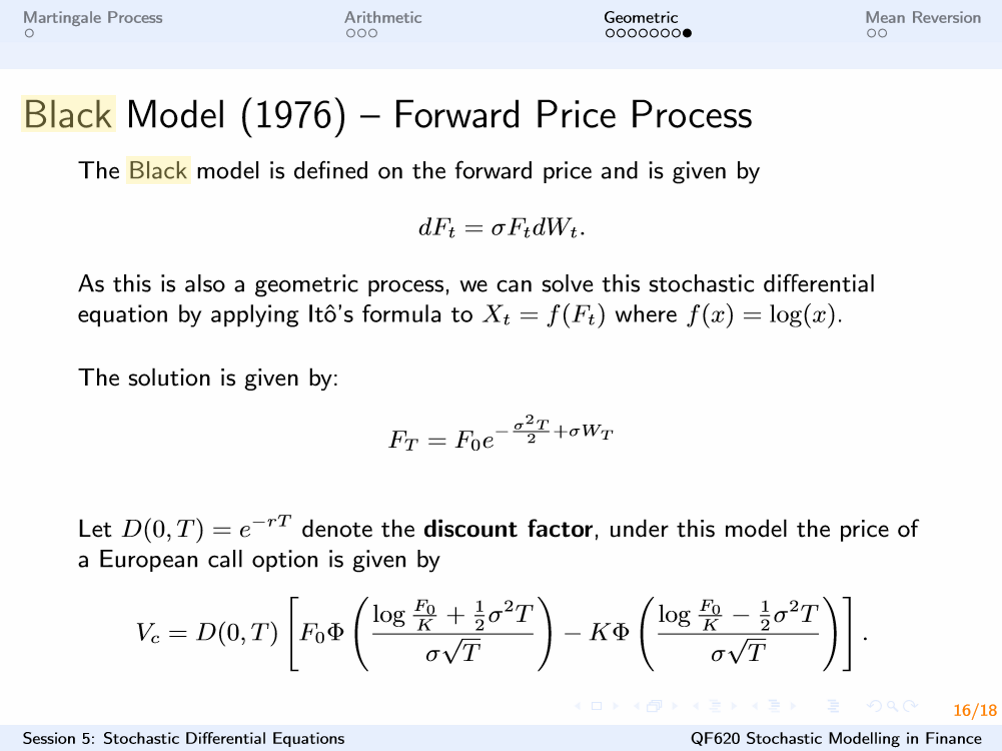

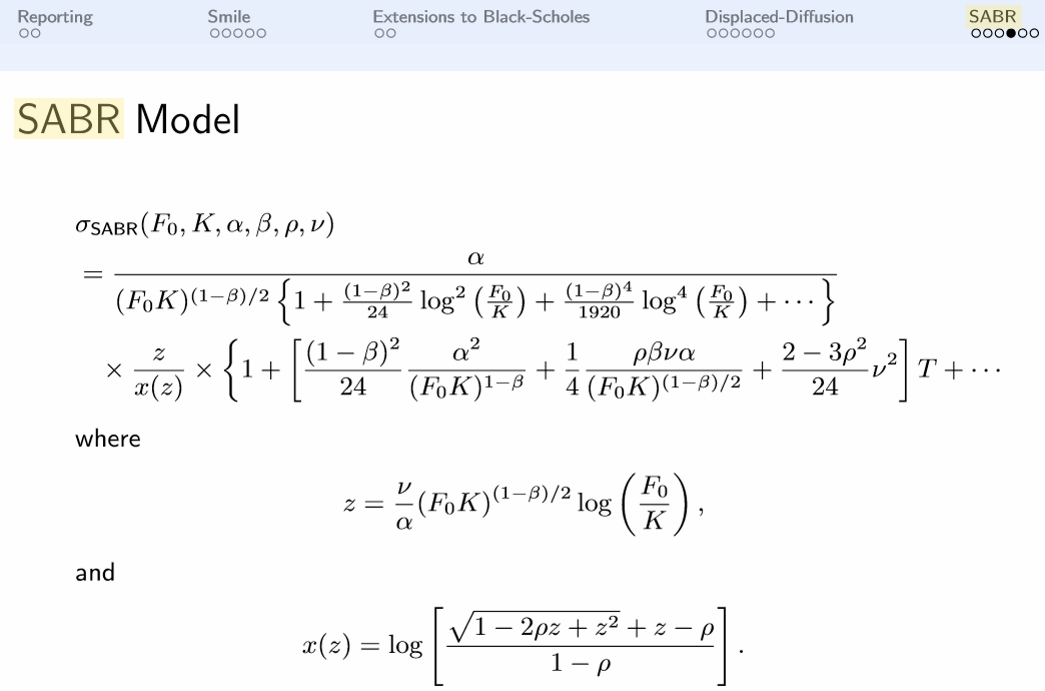

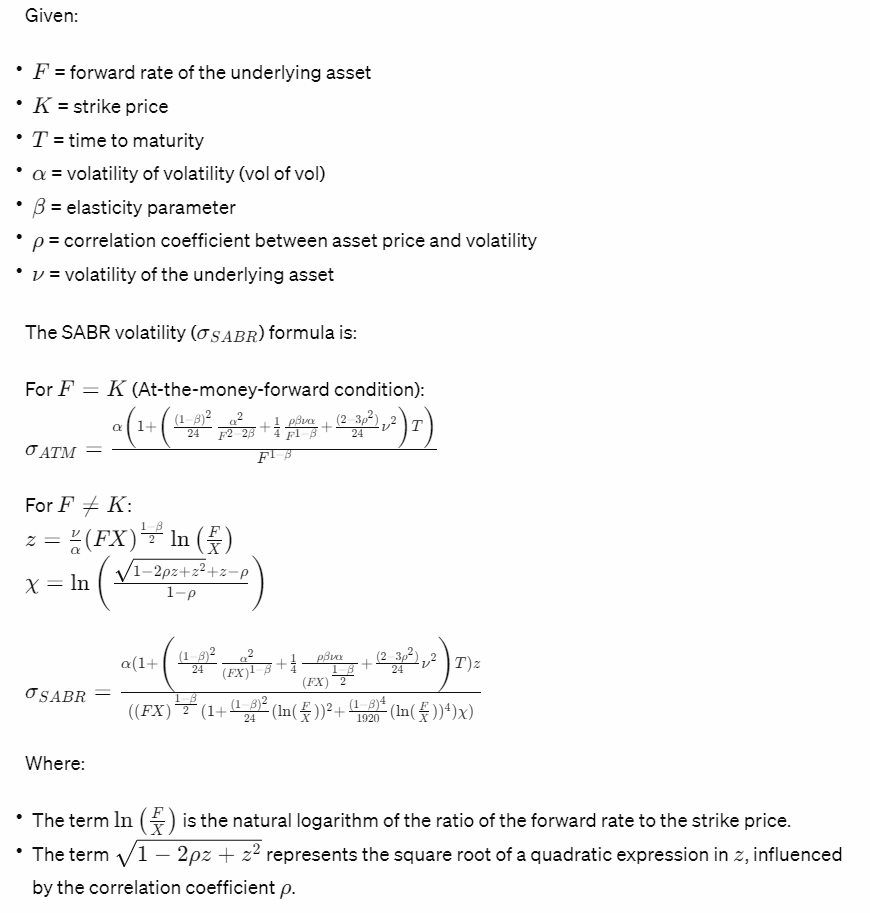

In [2]:
def Black76Call(S, K,disc, sigma, T):
    d1 = (np.log(S/K)+sigma**2/2*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return disc*(S*norm.cdf(d1) - K*norm.cdf(d2))

def Black76Put(S, K, disc,sigma, T):
    d1 = (np.log(S/K)+sigma**2/2*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return disc*(K*norm.cdf(-d2) - S*norm.cdf(-d1))

def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*log(F/X)
        zhi = log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

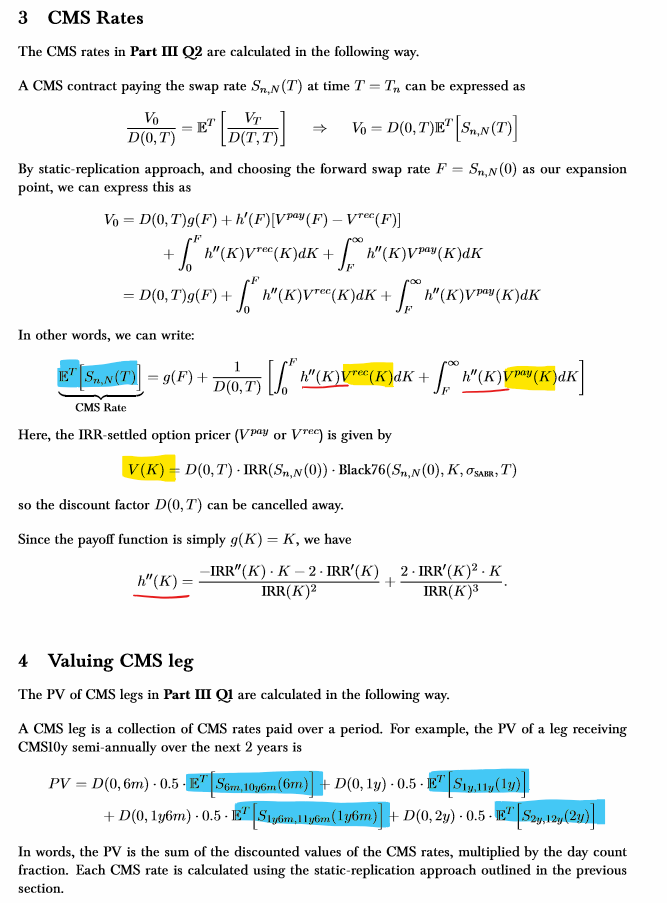

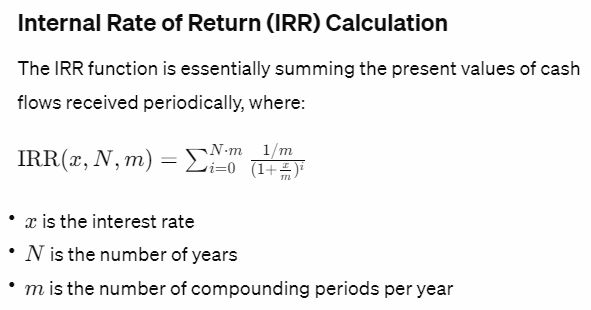

In [3]:
def IRR(x,N,m):
    IRR=np.zeros(N*m)
    IRRS=0
    for i in range(N*m):
        IRR[i]= 1/m / (1+x/m)**i
    IRRS=np.sum(IRR[:])
    return IRRS

def IRRf(x,N,m):
    dx = 0.05 * x
    IRRplus= IRR(x+dx,N,m)
    IRRminus = IRR (x-dx,N,m)
    IRRf = (IRRplus - IRRminus) / (2*dx)
    return IRRf

def IRRff(x,N,m):
    dx = 0.05 * x
    IRRplus= IRR(x+dx,N,m)
    IRRx = IRR(x,N,m)
    IRRminus = IRR (x-dx,N,m)
    IRRff = (IRRplus - 2*IRRx + IRRminus) / (dx**2)
    return IRRff

def hf(x, N, m):
    term1 = IRR(x, N, m) * (1/4) * x ** (-3 / 4)
    term2 = (x ** (1/4) - 0.2) * IRRf(x, N, m)
    return (term1 - term2) / (IRR(x, N, m)**2)

def hff(x, N, m):
    term1 = IRR(x, N, m) * (-3 / 16 * x ** (-7/4))
    term2 = IRRff(x, N, m) * (x**(1/4) - 0.2)
    term3 = 2 * IRRf(x, N, m) * (1/4) * x ** (-3/4)
    term4 = 2 * IRRf(x, N, m) ** 2 * (x ** (1/4) - 0.2)
    h = (term1 - term2 - term3) / (IRR(x,N,m)**2) + term4 / (IRR(x,N,m)**3)
    return h

def integral1(x,N,m,F,disc,sigma,T):
    h = hff(x, N, m)
    Vrec=Black76Put(F, x, disc, sigma, T)
    return h*Vrec

def integral2(x,N,m,F,disc,sigma,T):
    h = hff(x, N, m)
    Vpay=Black76Call(F, x, disc, sigma, T)
    return h*Vpay

In [4]:
data = pd.read_csv('CMS_10Y.csv', header = 0)

In [5]:
data

,Unnamed: 0,Start,Tenor,FS,DF,alpha,rho,nu,CMS
0,0,0.5Y,10Y,0.037845,0.998752,0.171130,-0.264831,0.777658,0.038037
1,1,1Y,10Y,0.038428,0.997009,0.171130,-0.264831,0.777658,0.038844
2,2,1.5Y,10Y,0.039020,0.995270,0.171793,-0.286815,0.742202,0.039691
3,3,2Y,10Y,0.039634,0.993531,0.172457,-0.308798,0.706746,0.040588
4,4,2.5Y,10Y,0.040200,0.991773,0.173120,-0.330782,0.671290,0.041458
5,5,3Y,10Y,0.040788,0.990015,0.173784,-0.352766,0.635834,0.042371
6,6,3.5Y,10Y,0.041412,0.988066,0.174447,-0.374750,0.600378,0.043340
7,7,4Y,10Y,0.042062,0.986117,0.175110,-0.396734,0.564922,0.044351
8,8,4.5Y,10Y,0.042831,0.984150,0.175774,-0.418717,0.529466,0.045507
9,9,5Y,10Y,0.043634,0.982184,0.176437,-0.440701,0.494010,0.046715


In [6]:
F = data.loc[9, 'FS']
D = data.loc[9, 'DF']
alpha = data.loc[9, 'alpha']
beta = 0.9
rho = data.loc[9, 'rho']
nu = data.loc[9, 'nu']
sigmasabr = SABR(F, 0.0016, 5, alpha, beta, rho, nu)

## 1. PV of CMS rate payoff 

In [7]:
term1 = F ** (1/4) - 0.2
term3 = quad(lambda x: integral1(x, 10, 2, F, IRR(F, 10, 2), sigmasabr, 5), 0, F)
term4 = quad(lambda x: integral2(x, 10, 2, F, IRR(F, 10, 2), sigmasabr, 5), F, np.inf)
PVoption = (term1 + term3[0] + term4[0]) * D # term3 = (-0.08883970376579886, 5.550310988589047e-09), first value is the result, second value is the absolute error
PVoption

0.2119204563103654

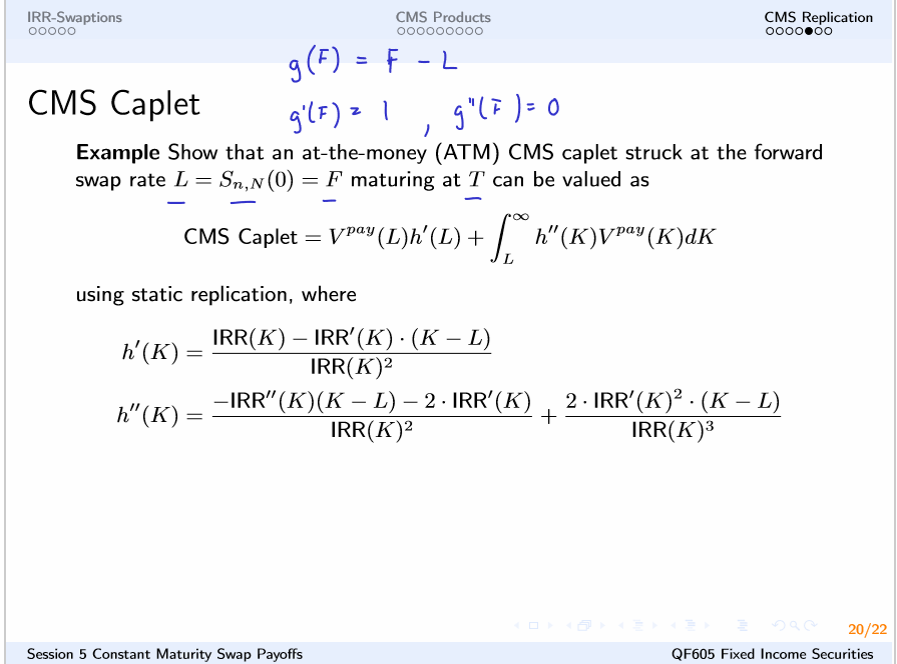

## 2. PV of CMS caplet payoff 

In [8]:
term5 = hf(0.0016, 10, 2) * Black76Call(F, 0.0016, IRR(F, 10, 2), sigmasabr, 5)
term6 = quad(lambda x: integral2(x, 10, 2, F, IRR(F, 10, 2), sigmasabr, 5), 0.0016, np.inf)
PVoption2 = (term5 + np.sum(term6)) * D

In [9]:
PVoption2

0.2158065222977602